## Avaliação em holdouts - Amazon Kindle

Interactions in the 'Amazon Kindle' dataset are SOMEWHAT well distributed.
Several users are present during the whole considered period (2014):
<!-- * 37067 users of 190248 (19.484%) occurr in 80.0% or more months. -->
* 3385 users of 5849 (57.873%) occurr in 80.0% or more months.

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [2]:
from data import ImplicitData, getBucketsHoldouts
from plot_utils import lineplot_recallxholdout, recall_heatmap
from dataset_evaluation_utils import *
from recommenders_implicit import ISGD, RAISGD, RSISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateHoldouts, EvaluateAndStore # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout

from datetime import datetime
import joblib
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

___
## BWT FWT

ACC, BWT, e FWT - Lopez-Paz e Ranzato GEM

In [3]:
def avg_recall(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    return np.mean( np.diag(results_matrix) )

def compute_BWT(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    BWT = []
    n_checkpoints = results_matrix.shape[0]
    for T in range(1, n_checkpoints): # 1 means holdout 2, 2 means 3, so on
        Rti = results_matrix.iloc[T, 0:T] # get models performances' on previous holdouts
        Rii = np.diag(results_matrix)[0:T] # get models performances' on their closest holdouts (diagonal)
        E = sum( Rti - Rii ) # future models performances' - performances' of models closest to holdouts (diagonal)
        BWT.append( E/T ) # store average BWT for model
    return BWT, np.mean( BWT ) # return BWT and average BWT for all models

def compute_FWT(results_matrix): # Díaz-Rodriguez et al. 2018
    upper_tri = results_matrix.to_numpy()[np.triu_indices(results_matrix.shape[0], k=1)]
    return np.mean(upper_tri)

___
# Amazon Kindle
Small subset, ratings only.  
https://nijianmo.github.io/amazon/index.html


### RAISGD

In [4]:
buckets = joblib.load('output/amazonkindle_dump/2nd_sample_buckets.joblib')
holdouts = joblib.load('output/amazonkindle_dump/2nd_sample_holdouts.joblib')

Hyperparameters

In [18]:
# importa dataset 'books playlists'
data = pd.read_csv('output/amazonkindle_dump/2nd_sampled_amazon_kindle.csv')
dataset_name = 'Amazon_Kindle'
user_col = 'user_id'
item_col = 'item_id'

In [20]:
%%time
import itertools
from eval_implicit import EvalPrequential
def grid_search(model, stream, random_seed = 10, interleaved=10):    
    num_factors = [100, 150, 200]
    num_iter = [2, 5, 8]
    learn_rate = [0.1, 0.25, 0.5]
    regularization = [0.3, 0.4, 0.5]
    num_nodes = [4, 8, 16]
    grid = [num_factors, num_iter, learn_rate, regularization, num_nodes]
    grid = list(itertools.product(*grid))
    results = []
    for i, hp in enumerate(grid):
        print(((i*100)/len(grid)), '%')
        empty_stream = ImplicitData([], [])
        nf, ni, lr, reg, nn = hp
        m = model(empty_stream, nf, ni, lr, reg, reg, random_seed)
        e = EvalPrequential(m, stream, metrics = ["Recall@N"])
        result = e.Evaluate(start_eval=0, count=stream.size, interleaved=interleaved)
        results.append( np.mean(result['Recall@N']) )
    return grid, results    

# OPTIONAL FOR NOW
prop = 0.05
hp_sample = data.iloc[:round( data.shape[0]*prop )]
stream = ImplicitData(hp_sample[user_col], hp_sample[item_col]) #(data['playlist_id'],data['track_id'])    
grid, results = grid_search(model=RAISGD, stream=stream, random_seed=10, interleaved=1 )
len(grid), len(results), max(results) # (243, 243, 0.003461128860489883)

0.0 %
0.411522633744856 %
0.823045267489712 %
1.2345679012345678 %
1.646090534979424 %
2.05761316872428 %
2.4691358024691357 %
2.880658436213992 %
3.292181069958848 %
3.7037037037037037 %
4.11522633744856 %
4.526748971193416 %
4.938271604938271 %
5.349794238683128 %
5.761316872427984 %
6.172839506172839 %
6.584362139917696 %
6.995884773662551 %
7.407407407407407 %
7.818930041152264 %
8.23045267489712 %
8.641975308641975 %
9.053497942386832 %
9.465020576131687 %
9.876543209876543 %
10.2880658436214 %
10.699588477366255 %
11.11111111111111 %
11.522633744855968 %
11.934156378600823 %
12.345679012345679 %
12.757201646090534 %
13.168724279835391 %
13.580246913580247 %
13.991769547325102 %
14.40329218106996 %
14.814814814814815 %
15.22633744855967 %
15.637860082304528 %
16.049382716049383 %
16.46090534979424 %
16.872427983539094 %
17.28395061728395 %
17.695473251028808 %
18.106995884773664 %
18.51851851851852 %
18.930041152263374 %
19.34156378600823 %
19.753086419753085 %
20.16460905349794 %

(243, 243, 0.002129925452609159)

In [21]:
print ( grid[ np.argmax( results ) ] )
num_factors, num_iter, learn_rate, regularization, num_nodes = grid[ np.argmax( results ) ] # (100, 8, 0.5, 0.3, 4)
# define hyperparameters (SAME AS LASTFM) ????
# num_factors = 160
# num_iter = 4
# learn_rate = 0.5
# regularization = 0.4
# num_nodes = 8

(100, 5, 0.5, 0.3, 4)


In [22]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte. recebe listas
# stream = ImplicitData(data[user_col], data[item_col])
# O modelo deve ser iniciado com uma lista vazia
empty_stream = ImplicitData([], [])
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = RAISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [23]:
%%time
# 30min 25s
# criamos instancia de EvaluateHoldouts para treinar o modelo e criar checkpoints
eval = EvaluateHoldouts(model=model, buckets=buckets, holdouts=holdouts)

CPU times: user 475 ms, sys: 83.5 ms, total: 558 ms
Wall time: 461 ms


In [24]:
%%time
# 1h 23min 37s
eval.Train_Evaluate(N_recommendations=20, exclude_known_items=True, default_user='none')

----------------------------------------------------------------------------------------------------
Train bucket 0
Test Holdout 0
Test Holdout 1
recommendations not made for users in holdout 1 x checkpoint 0: 1767
----------------------------------------------------------------------------------------------------
Train bucket 1
Test Holdout 0
Test Holdout 1
CPU times: user 2h 34min 4s, sys: 4h 32min 56s, total: 7h 7min 1s
Wall time: 1h 17min


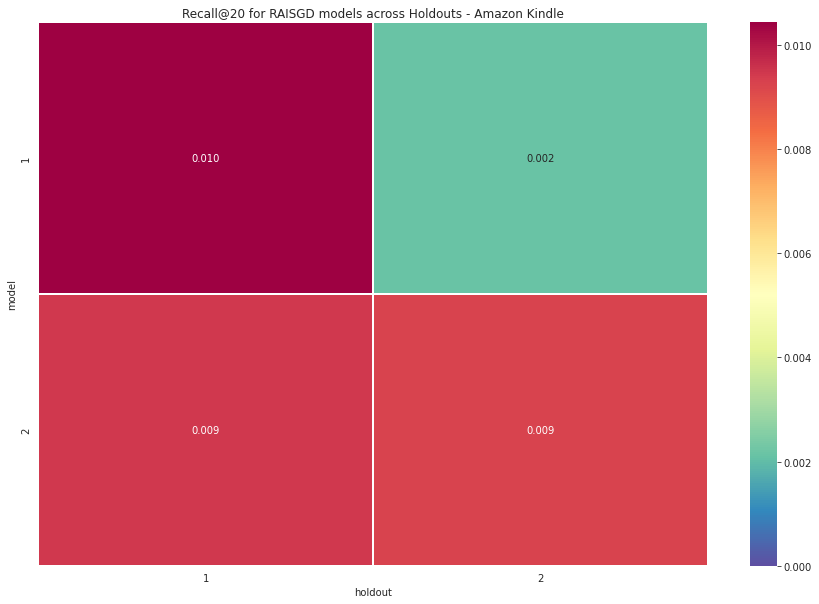

In [26]:
rm = eval.results_matrix
df = pd.DataFrame(rm)
df.to_csv('output/amazonkindle_dump/2nd_sample_amazon_kindle month_bucket RAISGD results.csv', index=False)
recall_heatmap(df,               
               round_point=3,
    title='Recall@20 for RAISGD models across Holdouts - Amazon Kindle',
    filepath='images/heatmaps/amazonkindle_dump/2nd_sample_amazon_kindle month_bucket RAISGD heatmap.png') #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

In [27]:
arecall = avg_recall(df)
arecall

0.009844311693599773

In [28]:
BWT, meanBWT = compute_BWT(df)
BWT, meanBWT

([-0.0009629272989889262], -0.0009629272989889262)

In [29]:
FWT = compute_FWT(df)
FWT
# que itens que usuario utilizou no passado e deixou de consumir o sistema ainda pode recomendar

0.0021245301519856184

In [31]:
joblib.dump(eval.IncrementalTraining_time_record, 'output/amazonkindle_dump/2nd_sample_amazon_kindle month_bucket RAISGD training time.joblib')
joblib.dump(eval.EvaluateHoldouts_time_record, 'output/amazonkindle_dump/2nd_sample_amazon_kindle month_bucket RAISGD eval time.joblib')

['output/amazonkindle_dump/2nd_sample_amazon_kindle month_bucket RAISGD eval time.joblib']

In [1]:
import pandas as pd
import numpy as np

def avg_recall(results_matrix):
    return np.mean( np.diag(results_matrix) )

def compute_BWT(results_matrix): # Díaz-Rodriguez et al. 2018
    diff = []
    n_checkpoints = results_matrix.shape[0]
    for i in range(1, n_checkpoints): # 1 means holdout 2, 2 means 3, so on
        for j in range(i):
            Rij = results_matrix.iloc[i,j] # get models performances' on previous holdouts
            Rjj = results_matrix.iloc[j,j] # get models performances' on their closest holdouts (diagonal)
            # print(Rij, Rjj)
            diff.append( Rij - Rjj ) # future models performances' - performances' of models closest to holdouts (diagonal)
            # print(diff)
    BWT = sum(diff) / ( n_checkpoints*(n_checkpoints-1) / 2 ) # store average BWT for model
    return BWT, diff # return BWT and average BWT for all models

def compute_FWT(results_matrix): # Díaz-Rodriguez et al. 2018
    upper_tri = results_matrix.to_numpy()[np.triu_indices(results_matrix.shape[0], k=1)]
    return np.mean(upper_tri)

In [2]:
df = pd.read_csv('output/amazonkindle_dump/2nd_sample_amazon_kindle month_bucket RAISGD results.csv')

In [9]:
avg_recall(df).round(5)

0.00984

In [10]:
BWT, diff = compute_BWT(df)
BWT.round(6)

-0.000963

In [11]:
compute_FWT(df).round(5)

0.00212